In [1]:
# Import Dependencies

import pandas as pd
from fbprophet import Prophet
import requests
from pprint import pprint
from datetime import datetime, timedelta
from bs4 import BeautifulSoup as bs
from sqlalchemy import create_engine


In [2]:
# AWS Server Details

server= "bootcampdb.cmwhqarpyd9v.ca-central-1.rds.amazonaws.com"
database = "postgres"
port ="5432"
username = "root"
password = "xy92Hdie"

conn = f"postgres://{username}:{password}@{server}:{port}/{database}"

In [3]:
# Read Bitcoin daily data from Alpha Vantage API

av_api_key = 'IYOYBP274BRSLPM0'

url = "https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=CAD&apikey={av_api_key}"

data = requests.get(url).json()
bc_data = data["Time Series (Digital Currency Daily)"]

In [4]:
# Loop through json response API data and transform into lists in python to create pandas dataframe

date = []
open_CAD = []
open_USD = []
high_CAD = []
high_USD = []
low_CAD = []
low_USD = []
close_CAD = []
close_USD = []
volume = []

date = list(bc_data.keys())

for d in date:
  value = bc_data[d]
  close_CAD.append(value['4a. close (CAD)'])
  close_USD.append(value['4b. close (USD)'])
  volume.append(value['5. volume'])
  open_CAD.append(value['1a. open (CAD)'])
  open_USD.append(value['1b. open (USD)'])
  high_CAD.append(value['2a. high (CAD)'])
  high_USD.append(value['2b. high (USD)'])
  low_CAD.append(value['3a. low (CAD)'])
  low_USD.append(value['3b. low (USD)'])

In [5]:
# Create Pandas dataframe

df = pd.DataFrame({"Date": date, "Open_USD": open_USD, "High_USD": high_USD,  "Low_USD": low_USD,  "Close_USD":close_USD})
df.head()




,Date,Open_USD,High_USD,Low_USD,Close_USD
0,2021-03-17,56900.74000000,57189.43000000,56340.76000000,56485.16000000
1,2021-03-16,55605.20000000,56938.29000000,53271.34000000,56900.75000000
2,2021-03-15,58976.08000000,60633.43000000,54600.00000000,55605.20000000
3,2021-03-14,61188.38000000,61724.79000000,58966.78000000,58968.31000000
4,2021-03-13,57221.72000000,61844.00000000,56078.23000000,61188.39000000


In [6]:
engine = create_engine(conn, echo=False)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning:

The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.



In [7]:
df.to_sql("coin_price", con=engine, if_exists = 'replace', index=False)

with engine.connect() as con:
    con.execute('ALTER TABLE "coin_price" ADD PRIMARY KEY ("Date");')

In [8]:
# Read Bitcoin crypto rating data from Alpha Vantage API


crypto_rating_url = 'https://www.alphavantage.co/query?function=CRYPTO_RATING&symbol=BTC&apikey={av_api_key}'

rating_data = requests.get(crypto_rating_url).json()

rating = rating_data['Crypto Rating (FCAS)']['3. fcas rating']
score = rating_data['Crypto Rating (FCAS)']['4. fcas score']
refresh_date = rating_data['Crypto Rating (FCAS)']['8. last refreshed']


In [9]:
# Create a pandas df

rating_df = pd.DataFrame({"Date": refresh_date, "Rank": rating, "Score": score}, index=[0])
rating_df['Date'] = pd.to_datetime(rating_df['Date'], infer_datetime_format=True)
rating_df['Date'] = rating_df['Date'].dt.strftime('%Y-%m-%d')

rating_df 

,Date,Rank,Score
0,2021-03-16,Superb,909


In [10]:
engine = create_engine(conn, echo=False)

In [11]:
rating_df.to_sql("rating", con=engine, if_exists = 'replace', index=False)

with engine.connect() as con:
    con.execute('ALTER TABLE "rating" ADD PRIMARY KEY ("Date");')

In [12]:
# Coin Market Cap URL of page to be scraped for Market Cap data

cmc_url = 'https://coinmarketcap.com/'

# Retrieve page with the requests module

response = requests.get(cmc_url)

# Create BeautifulSoup object; parse with 'html.parser'

soup = bs(response.text, 'html.parser')

In [13]:
#Scrape url for the data

results = soup.find_all('div', class_='sc-33i2yg-0 dOnegn')

for r in results:
  header = r.find_all('span', class_="sc-12ja2s9-0 eALoKW")
   
  title =[]
  value =[]
  for values in header:
    data = (values.text.split(":"))
    title.append(data[0])

    if data[0] == "Dominance":
      value.append(data[2][1:5])
    else:
      value.append(data[1][2:])



In [14]:
# create data table in pandas and clean up data

market_cap_df = pd.DataFrame({"Title": title, "Value": value})
market_cap_df = market_cap_df.drop(index=5)
market_cap_df = market_cap_df.transpose()
columns = market_cap_df.iloc[0].values
market_cap_df.columns = columns
market_cap_df.drop('Title', axis=0, inplace = True)
market_cap_df.reset_index(inplace=True)
market_cap_df = market_cap_df.drop(columns='index')
market_cap_df = market_cap_df.rename(columns={"Dominance": "BTC_Dominance", "Market Cap": "Market_Cap", "24h Vol": "24h_Volume"})
market_cap_df['Market_Cap'] = market_cap_df['Market_Cap'].str.replace("$","")
market_cap_df['24h_Volume'] = market_cap_df['24h_Volume'].str.replace("$","")
market_cap_df = market_cap_df.replace(',','', regex=True)
market_cap_df

,Cryptocurrencies,Markets,Market_Cap,24h_Volume,BTC_Dominance
0,8840,36555,1733590960292,136466566021,60.8


In [15]:
engine = create_engine(conn, echo=False)

In [16]:
market_cap_df.to_sql("market_cap", con=engine, if_exists = 'replace', index=False)

with engine.connect() as con:
    con.execute('ALTER TABLE "market_cap" ADD PRIMARY KEY ("Cryptocurrencies");')

In [17]:
#Use the NY Times API to pull recent Bitcoin news

nyt_api_key = 'AHD58yFBu6t1DV7UGF2hdMCyfo2PvaHq'
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?"

# Store a search term
query = "Bitcoin"

# Search for articles published between a begin date (90 days ago) and end date (current date)

end_date = datetime.today()
begin_date = end_date - timedelta(90)

end_date = end_date.strftime('%Y%m%d')
begin_date = begin_date.strftime('%Y%m%d')


query_url = f"{url}api-key={nyt_api_key}&q={query}&begin_date={begin_date}&end_date={end_date}"

# Retrieve articles
articles = requests.get(query_url).json()

In [18]:
# Transform API response into pandas df

headline = []
date = []
paragraph = []

articles_list = articles["response"]["docs"]

for article in articles_list:
  headline.append(article["headline"]["main"])
  date.append(article["pub_date"])
  paragraph.append(article["lead_paragraph"])

news_df = pd.DataFrame({"Date": date, "Headline": headline, "Paragraph": paragraph})
news_df['Date'] = pd.to_datetime(news_df['Date'], infer_datetime_format=True)
news_df['Date'] = news_df['Date'].dt.strftime('%Y-%m-%d')
news_df.head(10)



,Date,Headline,Paragraph
0,2021-03-09,Bitcoin’s Climate Problem,“Bitcoin uses more electricity per transaction...
1,2021-03-09,Why Bill Gates Is Worried About Bitcoin,Bitcoin is continuing to climb — its price is ...
2,2021-02-09,Bitcoin’s Big Day,Cryptocurrency prices are soaring after Tesla ...
3,2021-03-16,Twitter Hacker Pleads Guilty in Florida Court,The young hacker accused of being the mastermi...
4,2021-03-13,"From Crypto Art to Trading Cards, Investment M...",To hear more audio stories from publishers lik...
5,2021-03-01,China Charges Ahead With a National Digital Cu...,Annabelle Huang recently won a government lott...
6,2021-02-08,"Tesla says it bought $1.5 billion of Bitcoin, ...",The electric-car maker Tesla is known for buck...
7,2021-02-22,Billion-Dollar Paydays in a Pandemic,"Today, Institutional Investor unveiled the 20t..."
8,2021-02-22,Why an Animated Flying Cat With a Pop-Tart Bod...,To hear more audio stories from publishers lik...
9,2021-02-03,What Can You Actually Buy With Bitcoin?,"In the last twelve months, the value of a sing..."


In [19]:
engine = create_engine(conn, echo=False)

In [21]:
news_df.to_sql("btc_news", con=engine, if_exists = 'replace', index=False)

with engine.connect() as con:
    con.execute('ALTER TABLE "btc_news" ADD PRIMARY KEY ("Headline");')

**Facebook Prophet** Machine Learning

In [22]:
# Facebook Prophet Model Setup

fb_df = df[["Date", "Close_USD"]]
fb_df = fb_df.rename(columns={"Date": "ds", "Close_USD": "y"})
fb_df.head()

,ds,y
0,2021-03-17,56485.16000000
1,2021-03-16,56900.75000000
2,2021-03-15,55605.20000000
3,2021-03-14,58968.31000000
4,2021-03-13,61188.39000000


In [23]:
# Create fbProphet model and fit model 
model = Prophet()
model.fit(fb_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
# Model 90 days in the future

future_df = model.make_future_dataframe(periods=90)

In [25]:
#Make predictions

predictions = model.predict(future_df)
predictions.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1085,2021-06-11,70692.407082,73474.909747,82238.272878,66289.465610,74795.945337,7318.652309,7318.652309,7318.652309,8.767552,8.767552,8.767552,7309.884757,7309.884757,7309.884757,0.0,0.0,0.0,78011.059391
1086,2021-06-12,70909.432778,73377.289470,82928.402042,66331.833100,75089.833810,7352.240144,7352.240144,7352.240144,29.145854,29.145854,29.145854,7323.094290,7323.094290,7323.094290,0.0,0.0,0.0,78261.672923
1087,2021-06-13,71126.458475,73411.141263,82970.443988,66416.843892,75362.747285,7306.478253,7306.478253,7306.478253,-30.592982,-30.592982,-30.592982,7337.071235,7337.071235,7337.071235,0.0,0.0,0.0,78432.936728
1088,2021-06-14,71343.484171,73653.076048,83428.029363,66559.224137,75673.821810,7363.153522,7363.153522,7363.153522,11.650218,11.650218,11.650218,7351.503304,7351.503304,7351.503304,0.0,0.0,0.0,78706.637693
1089,2021-06-15,71560.509867,73889.327671,83398.208698,66702.050220,75979.073951,7335.792170,7335.792170,7335.792170,-30.242581,-30.242581,-30.242581,7366.034751,7366.034751,7366.034751,0.0,0.0,0.0,78896.302037


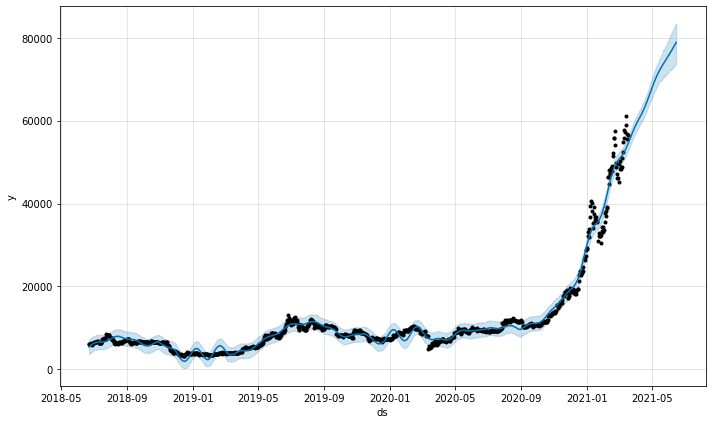

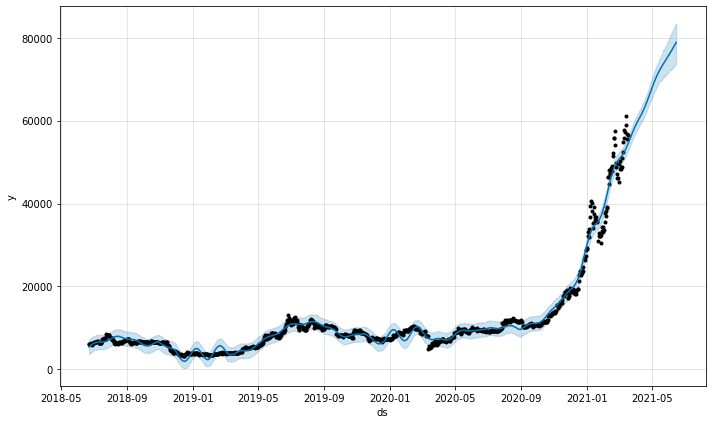

In [26]:
# Plot Predictions
model.plot(predictions)

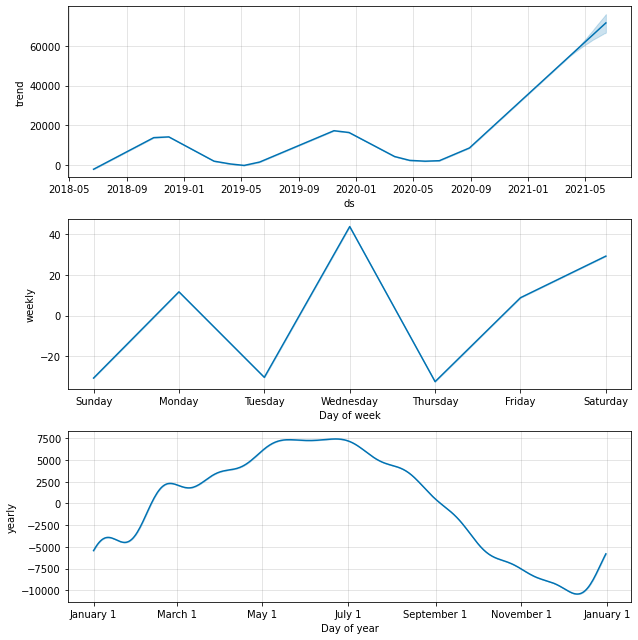

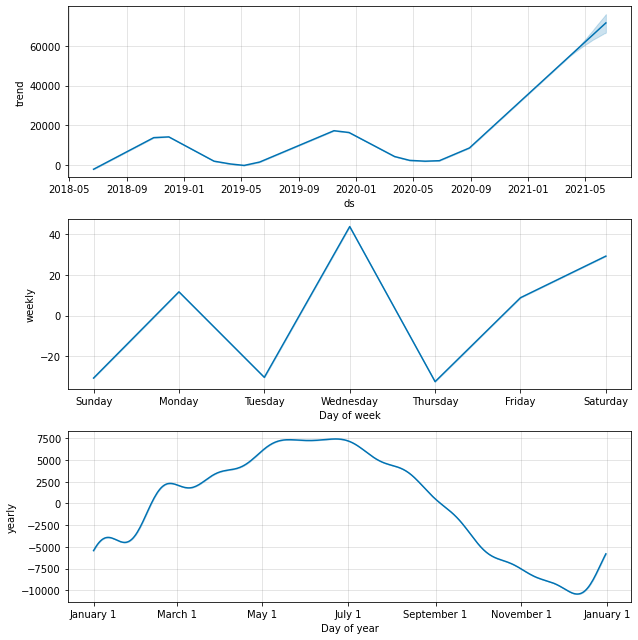

In [27]:
# Plot model components

model.plot_components(predictions)